This notebook will demonstrate how to use the **constrained training algorithms** implemented in this toolkit with **PyTorch**-like API.

The algorithms implemented in the **humancompatible.train.torch** subpackage share a similar idea. Before the training, you initialize an algorithm like you would a PyTorch one. Then, during the training process, you:

1. Evaluate a constraint and compute its gradient
2. Call the `dual_step` function to update dual parameters and save the constraint gradient for the primal update
3. Call the `step` function to update the primal parameters (generally, model weights)

Let's try the Stochastic Smooth Linearized Augmented Lagrangian (SSLALM) algorithm on a constrained learning task.

Let's train a simple classification model, putting a constraint on the norm of each layer's parameters.

In the canonical form, the algorithm expects equality constraints that are equal to 0; however, we can easily transform arbitrary inequality constraints to that form.

In [ ]:
# load and prepare data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(acs_data,categories=categories, dummies=True)

sens_cols = ['SEX_Female', 'SEX_Male']
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")
# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42)
# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train,dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

In [ ]:
from humancompatible.train.algorithms import SSLALM
import torch
from torch.nn import Sequential

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

hsize1 = 64
hsize2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

m = len(list(model.parameters()))

optimizer = SSLALM(
    params=model.parameters(),
    m=m,
    lr=0.01,
    dual_lr=0.1
)
# bounds for the constraints: norm of each param group should be <= 1
constraint_bounds = [1.]*m

epochs = 10
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(epochs):
    loss_log = []
    c_log = []
    slack_log = []
    duals_log = []
    for batch_input, batch_label in dataloader:
        # calculate constraints and constraint grads
        c_log.append([])
        for i, param in enumerate(model.parameters()):
            norm = torch.linalg.norm(param, ord=2)
            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )
            norm_viol.backward()
            # for the Lagrangian family of algorithms, dual_step requires the index of constraint and the value as arguments
            # to update the corresponding dual multiplier
            # in a stochastic-constrained setting, this estimate needs (in theory) to be independent from the one used to update dual parameters
            # in practice, it makes little difference  
            optimizer.dual_step(i, c_val=norm_viol)
            optimizer.zero_grad()
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        optimizer.step()
        optimizer.zero_grad()
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5694593191146851, constraints: [0.89587426 0.25025123 0.9878887  0.44957635 0.86241883 0.09738564], dual: [0.15030187 0.         0.14999658 0.         0.18364772 0.        ]
Epoch: 1, loss: 0.453301340341568, constraints: [0.99988097 0.6606871  0.9999979  0.6280859  0.9998277  0.1964759 ], dual: [0.20589583 0.         0.23529063 0.         0.2624111  0.        ]
Epoch: 2, loss: 0.43187829852104187, constraints: [0.9995572  0.95886993 0.99950653 0.6864315  0.9994035  0.19895783], dual: [0.24521847 0.02820662 0.29254287 0.         0.31646594 0.        ]
Epoch: 3, loss: 0.42199623584747314, constraints: [0.99928725 0.9997964  0.99919224 0.7160128  0.999049   0.19681479], dual: [0.27254534 0.03845146 0.33845595 0.         0.35972592 0.        ]
Epoch: 4, loss: 0.41544073820114136, constraints: [0.99918455 0.99972284 0.9989307  0.7367323  0.9987696  0.19203664], dual: [0.2950047  0.0444206  0.37791267 0.         0.3970336  0.        ]
Epoch: 5, loss: 0.4099986255168915, co

The model is now trained subject to the constraints we set.

---
---

It is also possible to train a network subject to **stochastic constraints**. One of the main use-cases for that is **fairness**. Let's train a network on the `folktables` dataset without constraints first, so we can identify some biases:

Define a model:

In [ ]:
from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_uncon = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

And start training:

In [ ]:
from torch.optim import Adam

loader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model_uncon.parameters())
epochs = 50

for epoch in range(epochs):
    losses = []
    for batch_feat, batch_label in dataloader:
        optimizer.zero_grad()

        logit = model_uncon(batch_feat)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, batch_label)
        loss.backward()

        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch: {epoch}, loss: {np.mean(losses)}")

Epoch: 0, loss: 0.4348257115075245
Epoch: 1, loss: 0.3961559882326184
Epoch: 2, loss: 0.38303964566988175
Epoch: 3, loss: 0.37115433783249435
Epoch: 4, loss: 0.357970049385259
Epoch: 5, loss: 0.3433566471881377
Epoch: 6, loss: 0.32670918229702645
Epoch: 7, loss: 0.3085799006635462
Epoch: 8, loss: 0.29297343726904235
Epoch: 9, loss: 0.27543243944912865
Epoch: 10, loss: 0.2603376112277886
Epoch: 11, loss: 0.24470395776741788
Epoch: 12, loss: 0.23123663239846043
Epoch: 13, loss: 0.2188801871337468
Epoch: 14, loss: 0.2071890614545893
Epoch: 15, loss: 0.19928035377145484
Epoch: 16, loss: 0.18748210149412034
Epoch: 17, loss: 0.17952393142863998
Epoch: 18, loss: 0.17391033132244393
Epoch: 19, loss: 0.1669990243477968
Epoch: 20, loss: 0.1594809728689319
Epoch: 21, loss: 0.15498915900841664
Epoch: 22, loss: 0.14732552946138033
Epoch: 23, loss: 0.1439602134080687
Epoch: 24, loss: 0.14057495150000077
Epoch: 25, loss: 0.13580133855572668
Epoch: 26, loss: 0.13342620257636606
Epoch: 27, loss: 0.1297

In [ ]:
from fairret.statistic import PositiveRate, TruePositiveRate
from fairret.loss import NormLoss

preds = torch.nn.functional.sigmoid(model_uncon(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3604, 0.5129], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

---
---

Now let us train the same model with one of the **constrained** training algorithms:

Here, to make sure each batch contains representatives of each protected group, we can use the BalancedBatchSampler from the `utils` subpackage - a custom PyTorch `Sampler` which yields an equal number of samples from each subgroup in each batch.

In [ ]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [ ]:
from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

from humancompatible.train.algorithms import SSLALM_Adam

optimizer = SSLALM_Adam(
    params=model_con.parameters(),
    m=1,
    lr=0.01,
    dual_lr=0.05,
    dual_bound=5,
    rho=1,
    mu=2,
)

# add slack variables
slack_vars = torch.zeros(1, requires_grad=True)
optimizer.add_param_group(param_group={"params": slack_vars, "name": "slack"})

epochs = 50

As the constraint, we use `NormLoss` from `fairret`, which penalizes the model based on the ratio between the value of a statistic for each group and the overall value: $\sum_{s\in S}{|1-\frac{f(\theta, X_s, y_s)}{f(\theta, X, y)}|}$.

In [ ]:
ep_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        # fair_constraint = torch.max(fair_loss + slack_vars[0] - fair_crit_bound, torch.zeros(1))
        fair_constraint = fair_loss + slack_vars[0] - fair_crit_bound
        fair_constraint.backward(retain_graph=True)
        
        optimizer.dual_step(0, c_val=fair_constraint)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        duals_log.append(optimizer._dual_vars.detach())
        # calculate loss and grad
        loss = criterion(out, batch_label) + 0 * slack_vars[0]
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step()
        optimizer.zero_grad()

        # slack variables must be non-negative. this is the "projection" step from the SSL-ALM paper
        with torch.no_grad():
            for s in slack_vars:
                if s < 0:
                    s.zero_()
        
    optimizer.dual_lr *= 0.95
    ep_c_log.extend(c_log)
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.4694157838821411, constraints: [0.1560765], dual: [0.06297961]
Epoch: 1, loss: 0.4001806378364563, constraints: [0.19225335], dual: [0.08156054]
Epoch: 2, loss: 0.38454315066337585, constraints: [0.19402348], dual: [0.02117708]
Epoch: 3, loss: 0.3777203857898712, constraints: [0.20150887], dual: [0.04982409]
Epoch: 4, loss: 0.369674950838089, constraints: [0.19956709], dual: [0.05890577]
Epoch: 5, loss: 0.36439797282218933, constraints: [0.19717683], dual: [0.02960703]
Epoch: 6, loss: 0.35590752959251404, constraints: [0.20243779], dual: [0.05908161]
Epoch: 7, loss: 0.34959983825683594, constraints: [0.2018306], dual: [0.08790541]
Epoch: 8, loss: 0.3418774902820587, constraints: [0.19918636], dual: [0.08040237]
Epoch: 9, loss: 0.33448490500450134, constraints: [0.19740554], dual: [0.05767368]
Epoch: 10, loss: 0.32761651277542114, constraints: [0.20275809], dual: [0.08063007]
Epoch: 11, loss: 0.3184966742992401, constraints: [0.19887009], dual: [0.07169671]
Epoch: 12, 

In [ ]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.3792, 0.4580], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [ ]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.1875, dtype=torch.float64, grad_fn=<SumBackward0>)

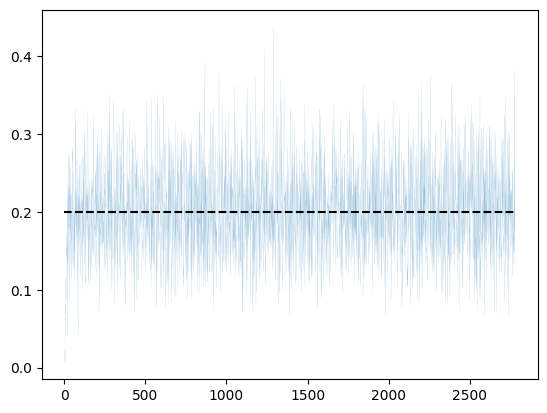

In [ ]:
from matplotlib import pyplot as plt

window_len = 5
c_mavg = np.array([np.mean(ep_c_log[i:i+window_len]) for i in range(0, len(ep_c_log), window_len)])
plt.plot(np.array(c_mavg).flatten(), lw=0.05)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors='black', ls='--')

---

Now let's see how the **Switching Subgradient** algorithm deals with this task.

In [ ]:
from fairret.statistic import PositiveRate
from fairret.loss import NormLoss
from humancompatible.train.fairness.utils import BalancedBatchSampler

dataset = torch.utils.data.TensorDataset(features_train, sens_train, labels_train)

sampler = BalancedBatchSampler(
    subgroup_onehot=sens_train,
    batch_size=128,
    drop_last=True
)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)

criterion = torch.nn.BCEWithLogitsLoss()

statistic = PositiveRate()
fair_criterion = NormLoss(statistic=statistic)
fair_crit_bound = 0.2

In [ ]:
from humancompatible.train.algorithms import SSG

from torch.nn import Sequential
hsize1 = 64
hsize2 = 32
model_con = Sequential(
    torch.nn.Linear(features_train.shape[1], hsize1),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize1, hsize2),
    torch.nn.ReLU(),
    torch.nn.Linear(hsize2, 1)
)

optimizer = SSG(
    params=model_con.parameters(),
    m=1,
    lr=0.05,
    dual_lr=0.05
)

epochs = 150

In [ ]:
ep_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    duals_log = []
    for batch_input, batch_sens, batch_label in dataloader:
        # calculate constraints and constraint grads
        out = model_con(batch_input)
        fair_loss = fair_criterion(out, batch_sens)
        fair_constraint = torch.max(fair_loss - fair_crit_bound, torch.zeros(1))
        fair_constraint.backward(retain_graph=True)
        
        optimizer.dual_step(0)
        optimizer.zero_grad()

        c_log.append([fair_loss.detach().item()])
        # calculate loss and grad
        # batch_output = model_con(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()
        loss_log.append(loss.detach().numpy())
        optimizer.step(fair_constraint)
        optimizer.zero_grad()
        
    ep_c_log.append(c_log)
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.5896381139755249, constraints: [0.05656339], 
Epoch: 1, loss: 0.43807604908943176, constraints: [0.11515142], 
Epoch: 2, loss: 0.4195421040058136, constraints: [0.1153449], 
Epoch: 3, loss: 0.4113629162311554, constraints: [0.11710171], 
Epoch: 4, loss: 0.40313923358917236, constraints: [0.11554368], 
Epoch: 5, loss: 0.4016948938369751, constraints: [0.12309138], 
Epoch: 6, loss: 0.3989124298095703, constraints: [0.11926389], 
Epoch: 7, loss: 0.3940858244895935, constraints: [0.11485945], 
Epoch: 8, loss: 0.39222854375839233, constraints: [0.1211241], 
Epoch: 9, loss: 0.3901630640029907, constraints: [0.11835493], 
Epoch: 10, loss: 0.38519927859306335, constraints: [0.12244802], 
Epoch: 11, loss: 0.3842395842075348, constraints: [0.12717817], 
Epoch: 12, loss: 0.38469749689102173, constraints: [0.12136279], 
Epoch: 13, loss: 0.3810117542743683, constraints: [0.11998166], 
Epoch: 14, loss: 0.37757983803749084, constraints: [0.12558044], 
Epoch: 15, loss: 0.373645454645

In [ ]:
from fairret.statistic import PositiveRate

preds = torch.nn.functional.sigmoid(model_con(features_train))
pr = PositiveRate()
pr(preds, sens_train)

tensor([0.4719, 0.4978], dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [ ]:
fair_criterion(model_con(features_train), sens_train)

tensor(0.0533, dtype=torch.float64, grad_fn=<SumBackward0>)

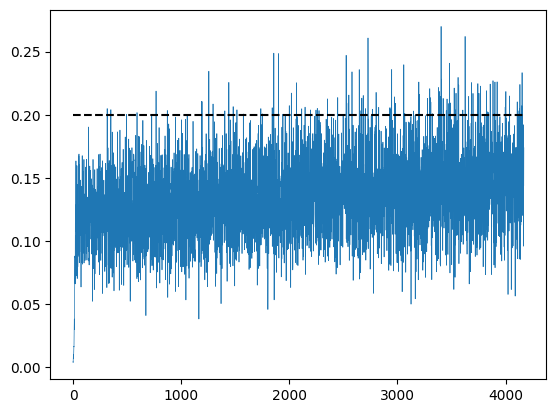

In [ ]:
from matplotlib import pyplot as plt

ep_c_log = np.array(ep_c_log).flatten()
window_len = 10
c_mavg = np.array([np.mean(ep_c_log[i:i+window_len]) for i in range(0, len(ep_c_log), window_len)])
plt.plot(np.array(c_mavg).flatten(), lw=0.5)
plt.hlines(y=fair_crit_bound, xmin=0, xmax=len(c_mavg), colors='black', ls='--')